# Masked Autoencoder with Extrapolator

This ipynb file summarizes prediction socres, discrimination scores and visulization of ExtraMAE. We also provide results of ablation study. 
**Full model files and supporting documents for running this note is available upon request.**

In [1]:
import os
import json
import argparse
import numpy as np
import pandas as pd
from modules.utils import load_dict_npy

In [ ]:
home = os.getcwd()
print(home)

In [3]:
def load_arguments(home):
    # Find the config for experiments
    parser = argparse.ArgumentParser()
    parser.add_argument('--config_dir', default='stock_config.json')
    args_dict = vars(parser.parse_args(args=[]))

    # Load the stock_config.json

    config_dir = args_dict['config_dir']

    with open(config_dir, 'r') as f:
        config_dict = json.load(fp=f)

    config_dict['home'] = home

    total_dict = {**config_dict, **args_dict}

    # Maintain dirs
    storage_dir = os.path.join(home, 'storage')
    total_dict['storage_dir'] = storage_dir

    experiment_dir = os.path.join(storage_dir, config_dict['experiment_name'])
    model_dir = os.path.join(experiment_dir, 'model')
    pics_dir = os.path.join(experiment_dir, 'pics')
    synthesis_dir = os.path.join(experiment_dir, 'synthesis')

    total_dict['experiment_dir'] = experiment_dir
    total_dict['model_dir'] = model_dir
    total_dict['pics_dir'] = pics_dir
    total_dict['synthesis_dir'] = synthesis_dir

    print(f'experiment_dir is {experiment_dir}')

    # Maintain dirs for Data
    datasets_dir = os.path.join(home, 'data')
    total_dict['datasets_dir'] = datasets_dir
    # dirs for specific dataset
    total_dict['stock_dir'] = os.path.join(datasets_dir, 'stock_data.csv')
    total_dict['energy_dir'] = os.path.join(datasets_dir, 'energy_data.csv')

    art_data_dir = os.path.join(model_dir, 'art_data.npy')
    ori_data_dir = os.path.join(model_dir, 'ori_data.npy')
    masks_dir = os.path.join(model_dir, 'masks.npy')
    total_dict['art_data_dir'] = art_data_dir
    total_dict['ori_data_dir'] = ori_data_dir
    total_dict['masks_dir'] = masks_dir

    args = argparse.Namespace(**total_dict)

    return args

In [4]:
def find_results(name):
    home = os.getcwd()
    storage_dir = os.path.join(home, 'storage')
    experiment_dir = os.path.join(storage_dir, name)
    model_dir = os.path.join(experiment_dir, 'model')
    synthesis_dir = os.path.join(experiment_dir, 'synthesis')
    
    random_once_dir = os.path.join(model_dir, 'metrics_results.npy')
    cross_average_dir = os.path.join(synthesis_dir, 'cross_average/metrics_results.npy')
    cross_concate_dir = os.path.join(synthesis_dir, 'cross_concate/metrics_results.npy')
    random_average_dir = os.path.join(synthesis_dir, 'random_average/metrics_results.npy')
    
    random_once = load_dict_npy(random_once_dir)[()]
    cross_average = load_dict_npy(cross_average_dir)[()]
    cross_concate = load_dict_npy(cross_concate_dir)[()]
    random_average = load_dict_npy(random_average_dir)[()]
    
    # print(f'keys are {random_once.keys()}')
    pred_mean_list = []
    pred_mean_list.append(random_once['pred_mean'])
    pred_mean_list.append(cross_average['pred_mean'])
    pred_mean_list.append(cross_concate['pred_mean'])
    pred_mean_list.append(random_average['pred_mean'])
    # print({pred_mean_list})
    
    pred_std_list = []
    pred_std_list.append(random_once['pred_std'])
    pred_std_list.append(cross_average['pred_std'])
    pred_std_list.append(cross_concate['pred_std'])
    pred_std_list.append(random_average['pred_std'])
    # print(pred_std_list)
    
    disc_mean_list = []
    disc_mean_list.append(random_once['disc_mean'])
    disc_mean_list.append(cross_average['disc_mean'])
    disc_mean_list.append(cross_concate['disc_mean'])
    disc_mean_list.append(random_average['disc_mean'])
    # print(disc_mean_list)
    
    disc_std_list = []
    disc_std_list.append(random_once['disc_std'])
    disc_std_list.append(cross_average['disc_std'])
    disc_std_list.append(cross_concate['disc_std'])
    disc_std_list.append(random_average['disc_std'])
    # print(disc_std_list)
    
    dataframe = pd.DataFrame({'pred_mean': pred_mean_list, 
                              'pred_std': pred_std_list, 
                              'disc_mean': disc_mean_list, 
                              'disc_std': disc_std_list}, 
                             index=['random once', 'cross average', 'cross concate', 'random average'])
    return dataframe

# Alation Study

We study the impact from autoencoder pretraining (AE) and embedding loss (EM). 
- AE5000_EM5000_RE50000: pretrainig as autoencoder for 5000 epoch, traing with embedding loss for 5000 epochs, training with reconstruction loss for 50000 epochs. 
- AE0_EM0_RE50000: no pretrainig as autoencoder, no embedding loss, training with reconstruction loss for 50000 epochs. 
- etc. 

In [5]:
AE5000_EM5000_RE50000 = find_results('AE5000_EM5000_RE50000')
AE5000_EM0_RE50000 = find_results('AE5000_EM0_RE50000')
AE0_EM5000_RE50000 = find_results('AE0_EM5000_RE50000')
AE0_EM0_RE50000 = find_results('AE0_EM0_RE50000')

ablation_min = pd.concat([AE5000_EM5000_RE50000.min(), AE5000_EM0_RE50000.min(), AE0_EM5000_RE50000.min(), AE0_EM0_RE50000.min()], axis=1)
ablation_min.columns = ['AER', 'AR', 'ER', 'R']
ablation_min = ablation_min.T
print(ablation_min)

     pred_mean  pred_std  disc_mean  disc_std
AER   0.037939  0.000189   0.084789  0.046658
AR    0.037846  0.000189   0.085402  0.069082
ER    0.037195  0.000172   0.132810  0.047714
R     0.037068  0.000150   0.071965  0.020396


# Prediction Scores and Discrimination Scores

In [6]:
def summary_pre_dis_scores():
    stock = find_results('AE0_EM0_RE50000_stock')
    sine = find_results('AE0_EM0_RE50000_sine')
    energy = find_results('AE0_EM0_RE50000_energy')
    stock_score = stock.loc['random once']
    sine_score = sine.loc['random once']
    energy_score = energy.loc['random once']
    stock_score_list = list(stock_score)
    sine_score_list = list(sine_score)
    energy_score_list = list(energy_score)
    scores = pd.DataFrame({'stock': stock_score_list, 
                           'sine': sine_score_list, 
                           'energy': energy_score_list}, 
                           index=['pred_mean', 'pred_std', 'disc_mean', 'disc_std'])
    scores = scores.T
    return scores

In [7]:
scores = summary_pre_dis_scores()
print(scores)

        pred_mean  pred_std  disc_mean  disc_std
stock    0.037010  0.000131   0.110437  0.116452
sine     0.101471  0.000693   0.113475  0.012641
energy   0.256548  0.000569   0.488372  0.014252


# Visualization

In [8]:
import os
import numpy as np

from matplotlib import pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [9]:
# plot utils
def plot_scatter(*args, **kwargs):
    # plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)

In [10]:
def pca_plot(ori_data, art_data, position, model_name, feature_name):
    pca = PCA(n_components=2)
    pca.fit(ori_data)
    pca_ori = pca.transform(ori_data)
    pca_art = pca.transform(art_data)

    plt.subplot(2, 6, position) 
    plt.grid()
    plot_scatter(pca_ori[:, 0], pca_ori[:, 1], color='b', alpha=0.1, label='Original')
    plot_scatter(pca_art[:, 0], pca_art[:, 1], color='r', alpha=0.1, label='Synthetic')
    plt.legend()
    plt.title(f'PCA for {feature_name} feature by {model_name}')
    plt.xlabel('x-pca')
    plt.ylabel('y-pca')

In [11]:
def tsne_plot(ori_data, art_data, position, model_name, feature_name):
    final_data = np.concatenate((ori_data, art_data), axis=0)
    len_data = 2000

    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(final_data)

    plt.subplot(2, 6, position)
    plt.grid()
    plot_scatter(tsne_results[:len_data, 0],
                 tsne_results[:len_data, 1],
                 color='b', alpha=0.1, label='Original')
    plot_scatter(tsne_results[len_data:, 0],
                 tsne_results[len_data:, 1],
                 color='r', alpha=0.1, label='Synthetic')
    plt.legend()
    plt.title(f't-SNE for {feature_name} feature by {model_name}')
    plt.xlabel('x-tsne')
    plt.ylabel('y-tsne')

In [12]:
def six_summary():
    home = os.getcwd()
    storage_dir = os.path.join(home, 'storage')
    
    sine_timegan_ori = np.load(storage_dir + '/sine_timegan_ori_data.npy')
    sine_timegan_art = np.load(storage_dir + '/sine_timegan_art_data.npy')
    sine_mai_ori = np.load(storage_dir + '/sine_mai_ori_data.npy')
    sine_mai_art = np.load(storage_dir + '/sine_mai_art_data.npy')
    
    stock_timegan_ori = np.load(storage_dir + '/stock_timegan_ori_data.npy')
    stock_timegan_art = np.load(storage_dir + '/stock_timegan_art_data.npy')
    stock_mai_ori = np.load(storage_dir + '/stock_mai_ori_data.npy')
    stock_mai_art = np.load(storage_dir + '/stock_mai_art_data.npy')
    
    energy_timegan_ori = np.load(storage_dir + '/energy_timegan_ori_data.npy')
    energy_timegan_art = np.load(storage_dir + '/energy_timegan_art_data.npy')
    energy_mai_ori = np.load(storage_dir + '/energy_mai_ori_data.npy')
    energy_mai_art = np.load(storage_dir + '/energy_mai_art_data.npy')
    
    len_data = 2000   # no more than 1000 points
    
    zero_timegan_ori = sine_timegan_ori[:len_data, :, 0]  # 0-th feature
    zero_timegan_art = sine_timegan_art[:len_data, :, 0]
    zero_mai_ori = sine_mai_ori[:len_data, :, 0]
    zero_mai_art = sine_mai_art[:len_data, :, 0]
    
    three_timegan_ori = sine_timegan_ori[:len_data, :, 3]  # 3-rd feature
    three_timegan_art = sine_timegan_art[:len_data, :, 3]
    three_mai_ori = sine_mai_ori[:len_data, :, 3]
    three_mai_art = sine_mai_art[:len_data, :, 3]
    
    close_timegan_ori = stock_timegan_ori[:len_data, :, 3] # close
    close_timegan_art = stock_timegan_art[:len_data, :, 3]
    close_mai_ori = stock_mai_ori[:len_data, :, 3]
    close_mai_art = stock_mai_art[:len_data, :, 3] 
    
    volumn_timegan_ori = stock_timegan_ori[:len_data, :, 5] # volumn
    volumn_timegan_art = stock_timegan_art[:len_data, :, 5]
    volumn_mai_ori = stock_mai_ori[:len_data, :, 5]
    volumn_mai_art = stock_mai_art[:len_data, :, 5] 
    
    app_timegan_ori = energy_timegan_ori[:len_data, :, 0] # application
    app_timegan_art = energy_timegan_art[:len_data, :, 0]
    app_mai_ori = energy_mai_ori[:len_data, :, 0]
    app_mai_art = energy_mai_art[:len_data, :, 0]
    
    T1_timegan_ori = energy_timegan_ori[:len_data, :, 2] # T1
    T1_timegan_art = energy_timegan_art[:len_data, :, 2]
    T1_mai_ori = energy_mai_ori[:len_data, :, 2]
    T1_mai_art = energy_mai_art[:len_data, :, 2]

    plt.figure(figsize=(30, 10))
    pca_plot(close_mai_ori, close_mai_art, 1, 'MAI', 'Close')
    pca_plot(volumn_mai_ori, volumn_mai_art, 2, 'MAI', 'volumn')
    pca_plot(zero_mai_ori, zero_mai_art, 3, 'MAI', '1-th')
    pca_plot(three_mai_ori, three_mai_art, 4, 'MAI', '4-th')
    pca_plot(app_mai_ori, app_mai_art, 5, 'MAI', 'Application')
    pca_plot(T1_mai_ori, T1_mai_art, 6, 'MAI', 'T1')
    
    pca_plot(close_timegan_ori, close_timegan_art, 7, 'TimeGAN', 'Close')
    pca_plot(volumn_timegan_ori, volumn_timegan_art, 8, 'TimeGAN', 'volumn')
    pca_plot(zero_timegan_ori, zero_timegan_art, 9, 'TimeGAN', '1-th')
    pca_plot(three_timegan_ori, three_timegan_art, 10, 'TimeGAN', '4-th')
    pca_plot(app_timegan_ori, app_timegan_art, 11, 'TimeGAN', 'Application')
    pca_plot(T1_timegan_ori, T1_timegan_art, 12, 'TimeGAN', 'T1')
    plt.savefig('pca_six_summary.png')
    
    plt.figure(figsize=(30, 10))
    tsne_plot(close_mai_ori, close_mai_art, 1, 'MAI', 'Close')
    tsne_plot(volumn_mai_ori, volumn_mai_art, 2, 'MAI', 'volumn')
    tsne_plot(zero_mai_ori, zero_mai_art, 3, 'MAI', '1-th')
    tsne_plot(three_mai_ori, three_mai_art, 4, 'MAI', '4-th')
    tsne_plot(app_mai_ori, app_mai_art, 5, 'MAI', 'Application')
    tsne_plot(T1_mai_ori, T1_mai_art, 6, 'MAI', 'T1')
    
    tsne_plot(close_timegan_ori, close_timegan_art, 7, 'TimeGAN', 'Close')
    tsne_plot(volumn_timegan_ori, volumn_timegan_art, 8, 'TimeGAN', 'volumn')
    tsne_plot(zero_timegan_ori, zero_timegan_art, 9, 'TimeGAN', '1-th')
    tsne_plot(three_timegan_ori, three_timegan_art, 10, 'TimeGAN', '4-th')
    tsne_plot(app_timegan_ori, app_timegan_art, 11, 'TimeGAN', 'Application')
    tsne_plot(T1_timegan_ori, T1_timegan_art, 12, 'TimeGAN', 'T1')
    plt.savefig('tsne_six_summary.png')

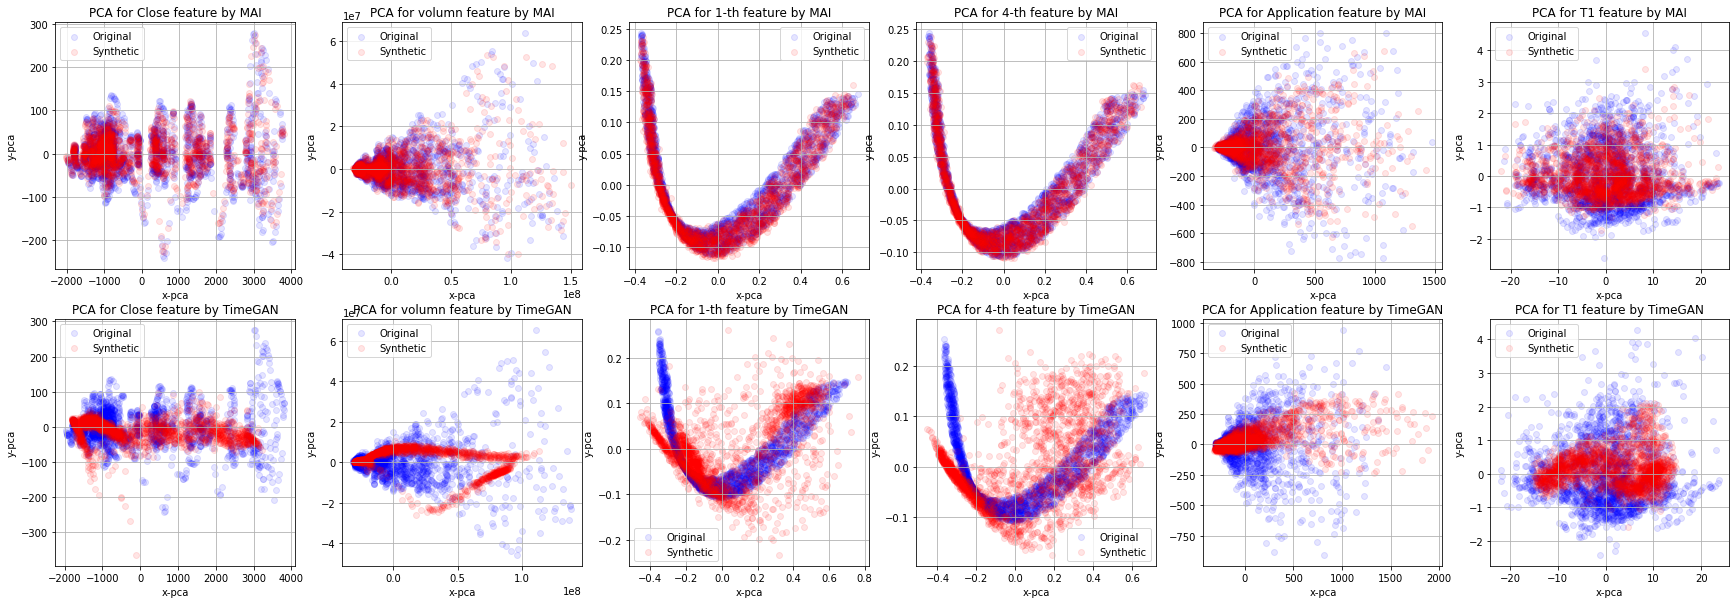

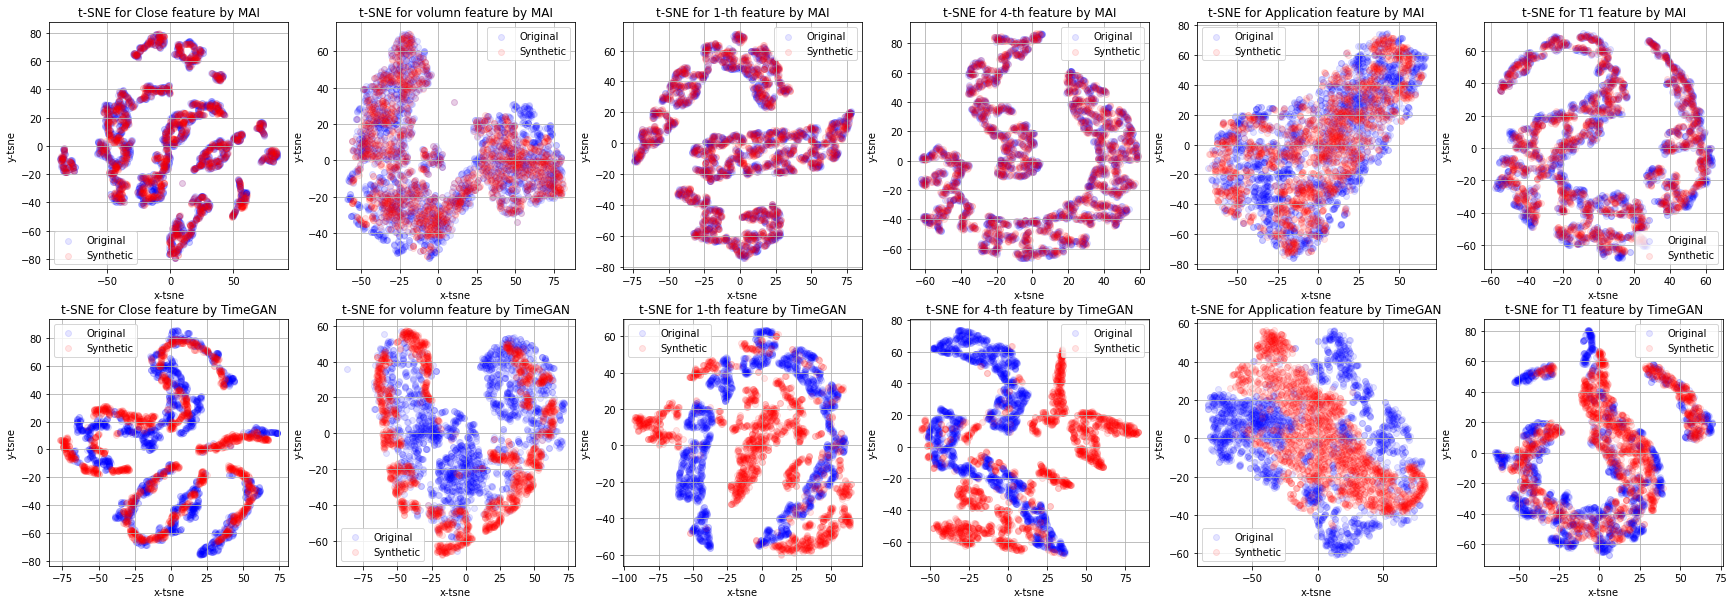

In [13]:
six_summary()

# Mask Ratio

We provide the results of the study on mask ratio under in **MaskRatio.ipynb**

# Imputation

We provide the results of imputation in **Imputation.ipynb**